# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> COMPSCI 109B: Advanced Topics in Data Science 
## Final Project: Using Deep Learning to Detect Thorax Diseases from Chest X-Ray Images


**Harvard University**<br/>
**Spring 2022**<br/>
**Authors:** Osvaldo Mendoza, Nick Lauer, Matt Sheridan, Rohan Sheth


<hr style="height:2pt">

In this project, we used subsets of a dataset containing 112,120 frontal-view chest X-ray images of 30,805 patients to attempt to accurately identify whether or not individuals have any combination of 14 different common thorax diseases. We built three different deep neural network models with different architecture and compared the performance of these models by looking at confusion matrices, F1 scores, and ROC/AUC curves. Our baseline model was a custom CNN architecture, our second was a transfer learning model based on VGG-16, and our third was also transfer learning based on the DenseNet-121 architecture. Analysis of all of the performance metrics reveals that the DenseNet model performed the best on average across disease classes while VGG-16 performed the worst. These models could be used to assist radiologists in predicting diseases, potentially guiding diagnoses and saving lives.

## Table of Contents
<hr style="height:2pt">

* [Introduction](#1)
* [Imports](#2)
* [Part 1: Data](#3)
    * [Data Description](#4)
    * [Loading and Resizing Images](#5)
    * [Data Preprocessing](#6)
    * [Exploratory Data Analysis](#7)
    * [Create Train, Validation, and Test Data](#8)
    * [Create TensorFlow Datasets](#9)
* [Part 2: Modeling](#10)
    * [Define Helpful Functions](#11)
    * [Model 1 - Custom CNN Baseline](#12)
    * [Model 2 - VGG16 Transfer Learning](#13)
    * [Model 3 - DenseNet121 Transfer Learning](#14)
* [Part 3: Evaluation](#15)
    * [Confusion Matrices](#16)
    * [F1 Scores](#17)
    * [ROC Curve / AUC Score](#18)
    * [GradCam/Saliency Maps](#19)
* [Part 4: Discussion](#20)
    * [Model Comparison](#21)
    * [Limitations](#22)
    * [Conclusion and Next Steps](#23)
* [Works Cited](#24)

## Introduction
<hr style="height:2pt">
<a class="anchor" id="1"></a>

Thorax diseases are chronic conditions that affect individuals in their chest region (Kudzinskas, Callahan). They can range from small hiatal hernias, a small separation resulting from the stomach pushing up on the diaphragm, to late stage emphysema, a pulmonary condition that is incurable and requires careful treatment (Mayo Clinic, American Lung Association). The significant area covered by the chest region, along with the high concentration of vital organs, make thorax diseases both very common and dangerous if undiagnosed.

When patients are experiencing pain in their chest region, one of the first steps that a healthcare provider takes is ordering a chest X-ray, which shows vital organs like the lung and the heart, and can reveal any foreign objects or abnormal masses (Mayo Clinic). X-rays, however useful, are two dimensional projections of a complex three dimensional object, which makes interpretation a daunting task. Good interpretation requires “through knowledge of the normal anatomy of the thorax, and the basic physiology of chest diseases…knowledge of clinical presentation and history, and knowledge of the correlation with other diagnostic results” (Delrue, Louke, et al.). These necessary skills are possessed by expert radiologists, but there are only around 30,000 active post-training radiologists in the United States, as compared to the approximately 152.8 million X-rays done a year (HealthManagement, Young). Additionally, even if the X-rays are being analyzed by experts in the field, the fact that multiple organs overlay one another makes disease classification prone to human error. 
    
Thus, the daunting task of how to efficiently and accurately use the wide breadth of X-ray image data available to correctly identify diseases remains. There has been recent success using deep learning approaches for medical diagnosis. In particular, using deep convolutional neural networks for classification has proved to be especially effective when classifying X-ray images into images presenting a patient with pneumonia vs a patient with no pneumonia (Yadav, Shivajirao). Additional work using that same data set has found that using the VGG16 model architecture when fitting the convolutional neural network had even more success (Naveen, Diwan).
    
In this project, we hope to extend some of the work on using machine learning for image classification. More specifically, we want to use chest X-ray image data to accurately diagnose whether or not individuals have any combination of 14 different common thorax diseases. 


## Imports
<hr style="height:2pt">
<a class="anchor" id="2"></a>

In [1]:
from IPython.display import Image
import glob
#FOR MAKING FILENAME LISTS ^
import numpy as np
from PIL import Image                                                                                
import matplotlib.pyplot as plt
import cv2 as cv
# FOR READING IMAGES ^
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout, Input, GlobalAveragePooling2D 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import keras.backend as K
import tensorflow as tf
import os

&nbsp;
&nbsp;
# PART 1: DATA
<hr style="height:2pt">
<hr style="height:2pt">
<a class="anchor" id="3"></a>

*In this section, we discuss the dataset we are working for this project and our work loading and preprocessing the dataset. We also explore preliminary EDA as well as the creation of the TensorFlow datasets for our model's to train and test on.*

## Data Description
<hr style="height:2pt">
<a class="anchor" id="4"></a>

We are working with the Chest X-ray dataset, created by Pranav Rajpurkar, an Assistant Professor of Biomedical Informatics at Harvard Medical School, and Kathy Yu, a Master’s student in computer science at Stanford University. The dataset is made up of 112,120 frontal-view X-ray images of 30,805 patients and the respective finding label resulting from analyzing the X-rays, along with certain biographical information, including age and gender. The finding label is either “No Finding” if no diseases were detected on the X-rays or a combination of 14 common thorax disease categories: Cardiomegaly, Emphysema, Effusion, Hernia, Infiltration, Mass, Nodule, Atelectasis, Pneumothorax, Pleural Thickening, Pneumonia, Fibrosis, Edema, and Consolidation.

## Loading and Resizing Images
<hr style="height:2pt">
<a class="anchor" id="5"></a>

Downloading the image data was a long process due to the size and number of images in the dataset. We were able to use the provided code from the dropbox given to download the tar files, then we iteratively read them in, resized them to (224, 224, 3), and read them back into 12 separate folders. Then, we used the glob package to read the filenames into a list, and we were able to use cv2’s imread function to read the files and view both the pixel arrays (as numbers) and the image itself. Below are some example images:

In [2]:
# #!/usr/bin/env python3
# # Download the 56 zip files in Images_png in batches

# # URLs for the zip files

# links = [
# 'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
# 'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz'
# 'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
# 'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
# 'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
# 'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
# 'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
# 'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
# 'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
# 'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
# 'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
# 'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
# ]

# for idx, link in enumerate(links):
#     fn = 'images_%02d.tar.gz' % (idx+12)
#     print('downloading'+fn+'...')
#     urllib.request.urlretrieve(link, fn)  # download the zip file

# print("Download complete. Please check the checksums")


#!tar -xvzf images_01.tar.gz -C "images_1"
# !tar -xvzf images_02.tar.gz -C "images_2"
# !tar -xvzf images_03.tar.gz -C "images_3"
# !tar -xvzf images_04.tar.gz -C "images_4"
# !tar -xvzf images_05.tar.gz -C "images_5"
# !tar -xvzf images_06.tar.gz -C "images_6"
# !tar -xvzf images_07.tar.gz -C "images_7"
# !tar -xvzf images_08.tar.gz -C "images_8"
# !tar -xvzf images_09.tar.gz -C "images_9"
# !tar -xvzf images_10.tar.gz -C "images_10"
# !tar -xvzf images_11.tar.gz -C "images_11"
# !tar -xvzf images_12.tar.gz -C "images_12"
# !tar -xvzf images_12.tar.gz -C "images_13"

# for i in range(2,14):
#     images = list(glob.iglob(f'images_{i}/images/*.png'))
#     for im in images:
#         read = cv.imread(im)
#         res = cv.resize(read,(224,224))
#         path = f'resized_images_new/{im.split("/")[2]}'
#         cv.imwrite(path,res)
#     print(i)

### ONLY HAVE TO RUN ONCE ###

# from zipfile import ZipFile

# with ZipFile('resized_images.zip','w') as z:
#     lst = list(glob.iglob('resized_images/*.png'))
#     for file in lst:
#         z.write(file)

# with ZipFile('resized_images.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    
#    lst = list(glob.iglob('resized_images/*.png'))
#    zipObj.extractall()

# Wow!

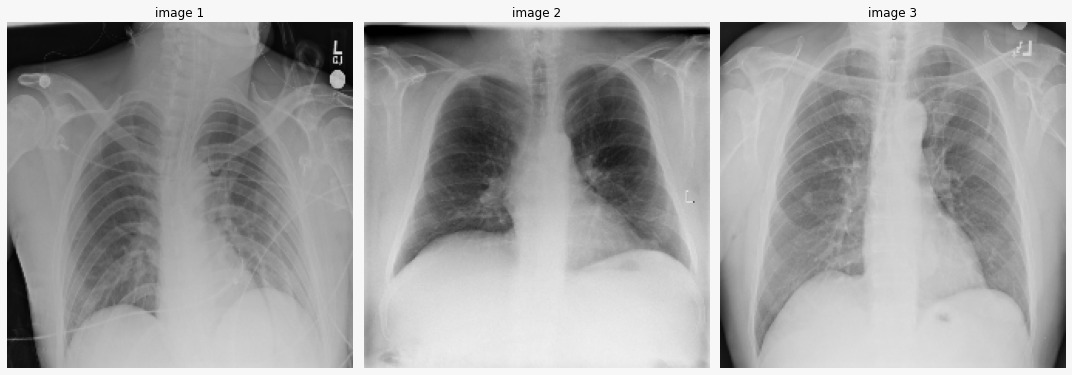

In [3]:
# display sample images
from IPython.display import Image
Image("ex_im.png")

## Data Preprocessing
<hr style="height:2pt">
<a class="anchor" id="6"></a>

The file "Data_Entry_2017_v2020.csv" contained the image indices (used in the file name of the images stored in the folders) for all 112,120 images. Additionally, for each image, it included the finding labels as a string, with each label separated by a "|", as well as the patient ID, and other biographical information for the X-ray's patient.

<span style=font-size:13pt;>Read in DataFrame</span>

In [4]:
#read in data
df = pd.read_csv("Data_Entry_2017_v2020.csv")
print("DataFrame Shape:", df.shape)
df.head()

DataFrame Shape: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


<span style=font-size:13pt;>Create Binary Variables</span>

Our first step after loading in the data was to create additional columns in our dataframe to more clearly represent the presence of various diseases. We started with a simple binary ‘Detect’ column indicating whether an individual had a disease or not. We then added another binary 'Female' column indicating whether an individual was female.

In [5]:
# create binary var to detect whether there was a finding or not
df['Detect'] = 1-(df['Finding Labels'] == 'No Finding')*(1)
#add numerical gender column
df["Female"] = (df['Patient Gender']=='F').astype(int)

From there, we added 14 more binary columns for each of the individual diseases listed above. This was a necessary step due to the fact that the original finding label column consisted of combinations of conditions, which we felt was not the best thing to try and predict given the large number of possible different combinations. Rather, for each of the 14 conditions, we will try and predict whether or not a given individual has that condition, while ensuring that they are not mutually exclusive; i.e., an individual can be predicted to have multiple conditions.

In [6]:
#create list of strings of diseases
df['Label Lists'] = df['Finding Labels'].str.split('|')

#add columns for each disease as binary
#https://stackoverflow.com/questions/52189126/how-to-elegantly-one-hot-encode-a-series-of-lists-in-pandas
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(df["Label Lists"]),
                   columns=mlb.classes_,
                   index=df["Label Lists"].index)

df = pd.concat([df, res], axis=1)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0


<span style=font-size:13pt;>Create Output Column</span>

Finally, we create an 'out' column that stacks each patient's binary labels for each disease into a list of 1's and 0's. The 'out' value for each column is a list of 14 binary variables that will be used as the response in our model training. 'No Finiding' isn't separately represented with a 1 or a 0, but instead is represented by all 14 values in 'out' being equal to 0 (i.e. each disease is not present).

In [7]:
#Creating output column as list of 0's and 1's
classes = ['Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
                                'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
                                'Emphysema','Fibrosis','Pleural_Thickening','Hernia']
classes.sort()
df['out'] = df[classes].values.tolist()
df['out'] = [np.array(item) for item in df['out']]

In [8]:
#Replacing no finding with nothing -> 14 labels
df['Finding Labels'] = df['Finding Labels'].map(lambda l: l.replace("No Finding", ''))
df['labs'] = df['Finding Labels'].str.split('|')

## Exploratory Data Analysis
<hr style="height:2pt">
<a class="anchor" id="7"></a>

<span style=font-size:13pt;>Examine Distrubition of Age</span>

The first step in our EDA was to observe if there were any discernible differences in the ages of individuals who had some disease detected versus those with no findings. As we can see in the histogram below, the majority of ages lie in the 50-70 range, with a longer tail on the left (younger ages) and a steeper dropoff on the right (older ages). 

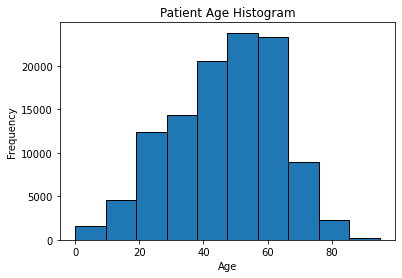

In [9]:
plt.hist(df['Patient Age'], edgecolor='black')
plt.title('Patient Age Histogram')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.show()

Below is a boxplot of distribution of age for those with no condition detected vs those with some conditions detected. The median age seems to be slightly higher for individuals with some conditions detected, but to see if this is a significant difference, we conducted a two sample t-test comparing these two groups and found a statistically significant difference, indicating that the mean age is significantly higher for those with conditions detected.

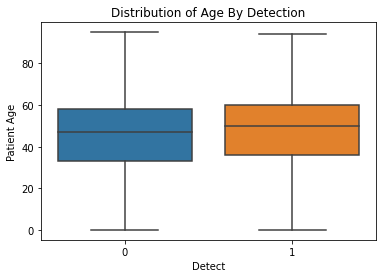

In [10]:
# create boxplot to show boxplots of age grouped by binary var 
age_det_box = sns.boxplot(x=df['Detect'], y=df['Patient Age']).set(title='Distribution of Age By Detection')
plt.show()

In [11]:
# two sample t test 
a = df.loc[df['Detect']==0, 'Patient Age']
b = df.loc[df['Detect']==1, 'Patient Age']
print("Two sample t-test result:", stats.ttest_ind(a, b))

Two sample t-test result: Ttest_indResult(statistic=-25.018785347301517, pvalue=9.144024548142709e-138)


<span style=font-size:13pt;>Examine Distribution of Gender</span>

Below is also a cross table with gender and a binary detect variable showcasing that the proportion of disease detection is higher for males. To see if this is significant, we conducted a chi squared test of independence and found that males were detected to have some combination of diseases at a slightly higher proportion than females. 

In [12]:
tab = pd.crosstab(index=df['Detect'], columns=df['Patient Gender'])
display(tab/tab.sum())
print("Chi Square test of independence:", stats.chi2_contingency(tab))

Patient Gender,F,M
Detect,,
0,0.542005,0.535554
1,0.457995,0.464446


Chi Square test of independence: (4.588143089352503, 0.03219387481568273, 1, array([[26261.23421334, 34099.76578666],
       [22518.76578666, 29240.23421334]]))


<span style=font-size:13pt;>Examine Frequencies of Conditions</span>

We then investigated the distribution of the different medical conditions across our dataset. The bar plot below shows the prevalence of each condition. The ‘No Finding’ label is omitted from this graph, but it accounts for the largest number of labels in the dataset (about 53.8%). Infiltrations, Effusion, and Atelectasis were the most prevalent. The large prevalence of ‘No Finding’ and the low prevalence of conditions like Hernia (about 0.2%) may make training a model to predict these conditions more difficult as it sees mostly ‘No Finding’ examples and few other labels. Essentially, we are dealing with significant class imbalance, so we will likely need to take steps to mitigate these concerns.

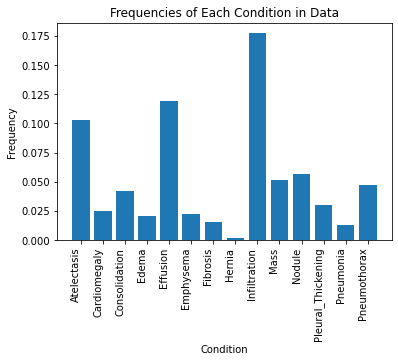

In [13]:
frequencies = {}

for classs in classes:
    frequencies[classs] = np.mean(df[classs])
    
plt.bar(frequencies.keys(),frequencies.values())
#https://www.pythoncharts.com/matplotlib/rotating-axis-labels/
plt.xticks(rotation=90, ha='right')
plt.title('Frequencies of Each Condition in Data')
plt.ylabel('Frequency')
plt.xlabel('Condition')
plt.show()

<span style=font-size:13pt;>Examine Conditions per Patient</span>

We also studied the counts of conditions that individuals in the dataset had by creating a new column in which we summed all of the binary columns for the individual conditions. As we can see in the histogram below, the majority of patients had 0 conditions (consistent with “No Finding”), and there is a right tail, where more individuals with conditions have fewer conditions, but there are small handfuls with multiple conditions. 

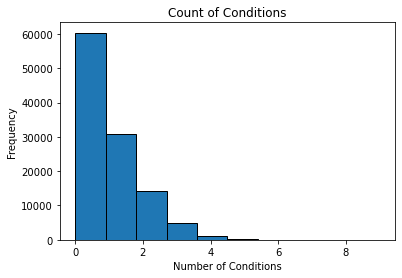

In [14]:
df['conditions_count'] = df['Atelectasis'] + df['Cardiomegaly'] + df['Effusion'] + df['Infiltration'] + df['Mass'] + df['Nodule'] + df['Pneumonia'] + df['Pneumothorax'] + df['Consolidation'] + df['Edema'] + df['Emphysema'] + df['Fibrosis'] + df['Pleural_Thickening'] + df['Hernia']
plt.hist(df['conditions_count'], edgecolor='black')
plt.title('Count of Conditions')
plt.xlabel('Number of Conditions')
plt.ylabel('Frequency')
plt.show()

We also studied the relationship between age and condition count. We notice in the scatterplot below  that the average condition count increases steadily with age (note that this cuts off extreme age values). This is intuitively what we’d expect as the older people get, the more likely they are to have one or more conditions. 


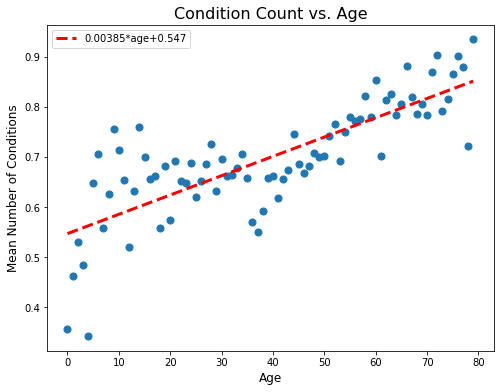

In [15]:
conditions_count_grouped = df.groupby('Patient Age')["conditions_count"].mean()
ages=conditions_count_grouped.index[:80]

plt.figure(figsize=(8,6))
conds = conditions_count_grouped[:80].values
plt.scatter(ages,conds, s=50)
m,b = np.polyfit(ages,conds,1)
plt.plot(ages, m*ages+b, label=f"{round(m,5)}*age+{round(b,3)}", linewidth=3, linestyle='dashed', color='red')
plt.xlabel("Age", fontsize=12)
plt.ylabel("Mean Number of Conditions", fontsize=12)
plt.title("Condition Count vs. Age", fontsize=16)
plt.legend()
plt.show()

## Create Train, Validation, and Test Data
<hr style="height:2pt">
<a class="anchor" id="8"></a>

Due to GPU, RAM, and time constraints, it would be very challenging to use the entire dataset of over 100,000 images, so we have elected to use a subset of the data in our modeling exercise. To take this subset, we split on patient ID instead of rows. This is a critical step, because it prevents data leakage, wherein different patients have X-ray images dispersed across the train, validation, and test data. which ensured that there would be no data leakage, as each patient has several images.

<span style=font-size:13pt;>Ensure Image Files Exist</span>

In [16]:
#List if images that we currently have
images_valid1 = (set(glob.iglob("resized_images/resized_images_new/*.png")))
images_valid2 = {item.split("/")[2] for item in images_valid1}
valid_indices = [ind for ind in df.index if df['Image Index'][ind] in images_valid2]

df = df.iloc[valid_indices].reset_index()

<span style=font-size:13pt;>Split into Train, Validation, and Test</span>

We chose to use a subset of 30% of the total dataset available to us. We further subset this data into 60% train set, 15% validation set, and 25% test set. This would allow us enough images to obtain meaningful training, while also limiting time needed to train each model.

In [17]:
# SPLITTING ON IDS, helping with data leakage

IDs = np.unique(df['Patient ID'])

#USING 30% subset for this notebook
ids_sub, _junk = train_test_split(IDs, random_state=109, test_size=0.70)
#train test split is 75 25
x_train_id1, x_test_id = train_test_split(ids_sub, random_state=109, test_size=0.25)
#train val split is 80/20
x_train_id, x_val_id = train_test_split(x_train_id1, random_state=109, test_size=0.20)

image_subset = df.iloc[[item in ids_sub for item in df['Patient ID']]]
x_train = df.iloc[[item in x_train_id for item in df['Patient ID']]]
x_val = df.iloc[[item in x_val_id for item in df['Patient ID']]]
x_test = df.iloc[[item in x_test_id for item in df['Patient ID']]]

<span style=font-size:13pt;>Ensure Representative Sample</span>

The first step is to ensure that the subset of data we took is representative of the whole dataset. We compare characteristics below:

In [18]:
print(f"The mean number of diseases per X-ray in the whole dataset: {np.mean(df.Detect):.4f}")
print(f'The std of num of disesases per X-ray in the whole dataset: {np.std(df.Detect):.4f}')
print(f'The mean number of diseases per X-ray in the subset: {np.mean(image_subset.Detect):.4f}')
print(f'The std of number of diseases per X-ray in the subset: {np.std(image_subset.Detect):.4f}')

The mean number of diseases per X-ray in the whole dataset: 0.4677
The std of num of disesases per X-ray in the whole dataset: 0.4990
The mean number of diseases per X-ray in the subset: 0.4679
The std of number of diseases per X-ray in the subset: 0.4990


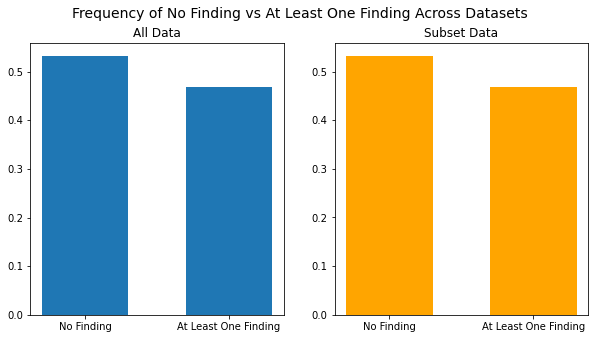

In [19]:
#creating barplots to show distribution of finding to one+ finding

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].bar(['No Finding', 'At Least One Finding'],
          [sum(df.Detect==0)/len(df.Detect), sum(df.Detect==1)/len(df.Detect)], width=0.6)
ax[1].bar(['No Finding', 'At Least One Finding'],
          [sum(image_subset.Detect==0)/len(image_subset.Detect), sum(image_subset.Detect==1)/len(image_subset.Detect)], color='orange', width=0.6)
fig.suptitle('Frequency of No Finding vs At Least One Finding Across Datasets', fontsize=14)
ax[0].set_title('All Data')
ax[1].set_title("Subset Data")
plt.show()

Notice that both the mean and standard deviation of diseases per X-ray is comparable across the subset and the whole dataframe. Thus, we can see that the distribution of number of diseases per X-ray in our subset matches that of the entire dataframe. Also notice that the frequency of finding and no finding is nearly identical across the two. Thus, using the subset should be a representative sample of the whole dataset. We now compare the train, validation, and test characteristics to check balance:

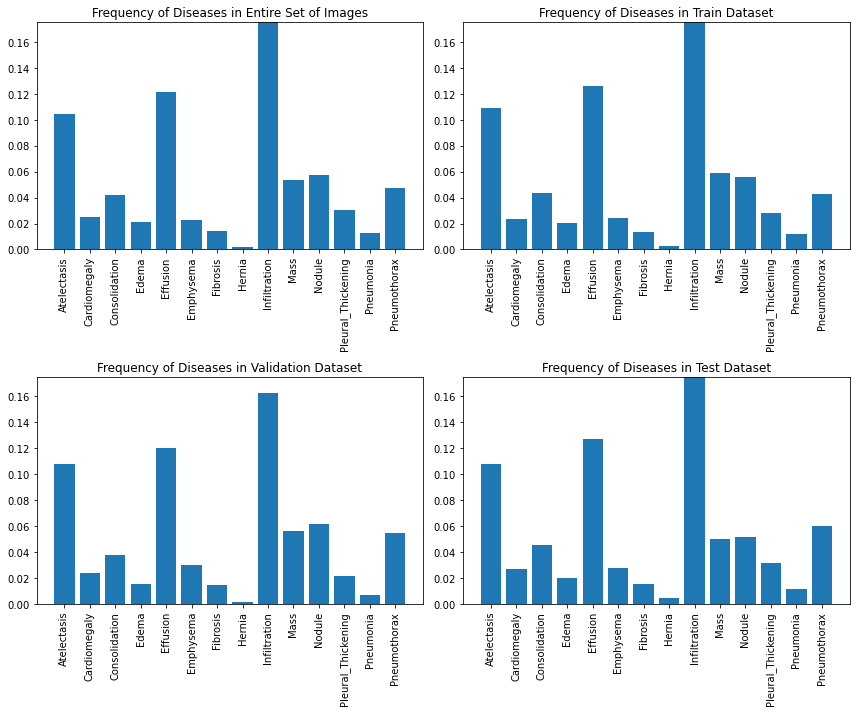

In [20]:
# Showing frequency of data subsets' findings
fig,ax = plt.subplots(2,2,figsize=(12,10))
dfs = [df, x_train, x_val, x_test]
titles = ["Entire Set of Images", "Train Dataset", "Validation Dataset", "Test Dataset"]
for i in range(len(dfs)):
    ax[i//2][i%2].bar(classes,np.mean(dfs[i].out))
    ax[i//2][i%2].tick_params(axis='x', rotation=90)
    ax[i//2][i%2].set_ylim([0, 0.175])
    ax[i//2][i%2].set_title(f'Frequency of Diseases in {titles[i]}')
plt.tight_layout()
plt.show()

We can also see above that the distributions of the frequencies of the various diseases are very similar across the main dataframe and our train, validation, and test data. In the end, it seems that each of our samples is representative of the entire dataset in these critical ways, so we will proceed to the modeling process.

## Create TensorFlow Datasets
<hr style="height:2pt">
<a class="anchor" id="9"></a>

We decided to cast our data into a TensorFlow dataset because this would allow us to efficiently shuffle and batch the images. This is especially useful with this dataset because it’s very large and we want to ensure that the samples that we use to train and test on are representative of the whole dataset. Using TF datasets also greatly reduces the time that it takes to train our models, which was useful for a project with a time constraint. 

In [21]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # turn off tensorflow warnings
#https://stackoverflow.com/questions/67538927/insufficient-memory-when-training-multi-label-classification-model
#make images correct size
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_png(image_string, channels=3)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [240, 240])

    return image, label

#Get filenames for each dataset
filenames_train =("resized_images/resized_images_new/" + x_train['Image Index'])
filenames_val =("resized_images/resized_images_new/" + x_val['Image Index'])
filenames_test =("resized_images/resized_images_new/" + x_test['Image Index'])

#Get the labels for each ds
labels_train = [item for item in x_train['out']]
labels_train=tf.cast(labels_train, tf.float32)

labels_val = [item for item in x_val['out']]
labels_val=tf.cast(labels_val, tf.float32)

labels_test = [item for item in x_test['out']]
labels_test = tf.cast(labels_test, tf.float32)

#Create dataset
dataset_train = tf.data.Dataset.from_tensor_slices((filenames_train, labels_train))
dataset_train = dataset_train.map(parse_function, num_parallel_calls=4)
dataset_val = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))
dataset_val = dataset_val.map(parse_function, num_parallel_calls=4)
dataset_test = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))
dataset_test = dataset_test.map(parse_function, num_parallel_calls=4)

In [22]:
print("Number of Images in Train Dataset:", tf.data.experimental.cardinality(dataset_train).numpy())
print("Number of Images in Validation Dataset:", tf.data.experimental.cardinality(dataset_val).numpy())
print("Number of Images in Test Dataset:", tf.data.experimental.cardinality(dataset_test).numpy())

Number of Images in Train Dataset: 18505
Number of Images in Validation Dataset: 4373
Number of Images in Test Dataset: 7608


Finally, we have Train, Validation and Test Datasets!

&nbsp;
&nbsp;
# PART 2: MODELING
<hr style="height:2pt">
<hr style="height:2pt">
<a class="anchor" id="10"></a>

*In this section, we construct and fit three separate Neural Network models for predicting the presence of each of the 14 diseases based on the X-ray images. The first is a custom CNN, while the second and third employ transfer learning from VGG-16 and DenseNet-121, respectively.*

## Define Helpful Functions
<hr style="height:2pt">
<a class="anchor" id="11"></a>

<span style=font-size:13pt;>Note on Weighted Loss to Address Class Imbalance</span>

Importantly, when we have class imbalance, trained models can often only pick a single outcome, no matter what the image looks like, due to the fact that the overwhelming majority of images are of a single class and predicting that every time can decrease loss over trying to change up predictions. However, in order for our model to have any practical value, we want to avoid this situation. The way we do this is by using weighted loss, which is implemented in the next two functions. As the name implies, weighted loss essentially "weighs" the loss more heavily if we are predicting infrequent classes, so the model doesn't neglect to ever predict these. In our example, this might be something like Hernias--without the weighting, a loss-minimizing model would probably not predict Hernias very often, so weighting the loss on this class more forces the optimal model to attempt to predict it, rather than predicting no hernia every time.

<span style=font-size:13pt;>Functions</span>

The below function, from the source linked in the comment at the top of the cell, is used to compute the frequency of each class. Once we have them, we set positive and negative weights, which will be important in using a weighted loss function, due to class imbalance issues.

In [23]:
# https://www.kaggle.com/code/redwankarimsony/nih-chest-x-ray8-classifier-cnn-visualization/notebook
    
#Computing class frequencies for use in the weighted loss function, it's on the train data    

def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = len(labels)
    positive_frequencies = (sum(labels))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies

In [24]:
# call above function and set positive and negative weights
labels = [np.array(item) for item in x_train['out']]
freq_pos, freq_neg = compute_class_freqs(labels)
pos_weights = freq_neg
neg_weights = freq_pos

The below function, from the source linked in the comment at the top of the cell, enables us to calculate the weighted loss. We will use this in training in order to deal with class imbalance as mentioned above:

In [25]:
# https://www.kaggle.com/code/redwankarimsony/nih-chest-x-ray8-classifier-cnn-visualization/notebook

#Using the kaggle link to help us get weighted loss function for use in our model

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

    return weighted_loss

Below is a helper function we will call to plot the loss, accuracy, and F1 score of our models as we train them.

In [26]:
#Function to graph loss, accuracy, and f1_score

def graph_history(history):
    fig, axs =plt.subplots(1,3,figsize=(18,4))

    axs[0].plot(history['loss'],linewidth=3, label='Training')
    axs[0].plot(history['val_loss'],linewidth=3, label='Validation', alpha=0.7)
    axs[0].set_ylabel('loss')

    axs[1].plot(history['acc'], linewidth=3, label='Training')
    axs[1].plot(history['val_acc'], linewidth=3, label='Validation', alpha=0.7)
    axs[1].set_ylabel("accuracy")
    
    axs[2].plot(history['f1_score'], linewidth=3, label='Training')
    axs[2].plot(history['val_f1_score'], linewidth=3, label='Validation', alpha=0.7)
    axs[2].set_ylabel("f1_score")

    titles = ['Weighted Binary Crossentropy Loss', "Accuracy", "F1 Score"]
    for ax, title in zip(axs, titles):
        ax.set_xlabel("Epoch")
        ax.set_title(title)
        ax.legend()

## Model 1 - Custom CNN Baseline
<hr style="height:2pt">
<a class="anchor" id="12"></a>

<span style=font-size:13pt;>Model Architecture</span>

The first model we explored was a custom CNN architecture with four convolutional layers and max-pooling layers after each. It used a flatten and then two dense layers before the output layer. Each convolutional layer had 16 filters and used a 3x3 kernel. Additonally, we used dropout in between the dense layers. The output is a dense layers with 14 outputs (one for each disease) and uses sigmoid activation that gives us a probability that each label is present. This was a basic model with relatively few layers and parameters which we used to give us a baseline for our model. We specifically chose to use a CNN because the X-ray inputs are image data, so we want to utilize the positional nature of pixels.

In [27]:
K.clear_session()

# create architecture
def create_cnn(s=(240,240,3), num_filters=16, pool=2, dropout=0.5, dense_units=128, num_labels=14):
    inputs = Input(s)
    x = Conv2D(num_filters, (3,3), padding='same', activation="relu")(inputs)
    x = MaxPooling2D(pool)(x)
    x = Conv2D(num_filters, (3,3), padding='same', activation="relu")(x)
    x = MaxPooling2D(pool)(x)

    x = Conv2D(num_filters*2, (3,3), padding='same', activation="relu")(x)
    x = MaxPooling2D(pool)(x)
    x = Conv2D(num_filters*2, (3,3), padding='same', activation="relu")(x)
    x = MaxPooling2D(pool)(x)

    x = Flatten()(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(dense_units, activation="relu")(x)
    outputs = Dense(num_labels, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="init_model")
    return model


model1 = create_cnn()
f1_metric = tfa.metrics.F1Score(14,average='weighted')

# model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, amsgrad=False)
#                ,loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['acc', f1_metric])

<span style=font-size:13pt;>Model Training</span>

In training our model, we call the "get_weighted_loss" function which returns a binary cross-entropy loss weighted to account for the class imbalance of the labels. We also print out the accuracy and F1 score (a weighted average of the f1 score of each class) at each epoch to give us a sense of how the model is doing. The F1 score can be more informative than the the simple accuracy as it accounts for class imbalance. The discussion of the models later in this notebook contains more on the F1 score and it's meaning. 

We fit our model on the training dataset, with a batch size of 64. While training, we pass our validation dataset to the neural network to evaluate its performance and give us a sense for when the model begins overfitting. We output the validation loss at each step, and we specifically implement an Early Stopping callback that terminates the fitting if the validation loss does not improve for 10 epochs. The Early Stoppiing callback restores the model to the weights of the best model based on validation loss.

We chose to run the model for a maximum of 50 epochs with a learning rate of 1e-4 as this seemed appropriate to give us sufficient time for the model to learn. The results of the training are shown below:

In [28]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
# history1 = model1.fit(dataset_train.batch(64).shuffle(buffer_size=64,seed=109,
#                                                     reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE), 
#                     validation_data=dataset_val.batch(64).shuffle(buffer_size=64,seed=109,
#                                                     reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE), 
#                               epochs=50,
#                              callbacks = [es])

In [29]:
# model1.save_weights("Baseline_trained_model_weights.h5")
model1.load_weights("Baseline_trained_model_weights.h5")

In [30]:
# np.save('history1.npy',history1.history)
history1=np.load('history1.npy',allow_pickle='TRUE').item()

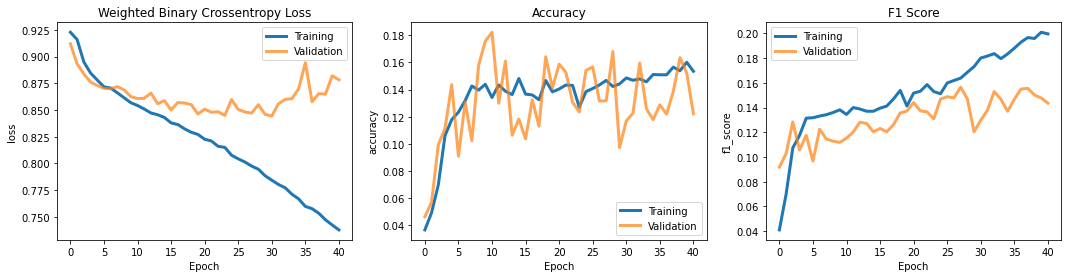

In [31]:
graph_history(history1)

Notice that this model has steadily decreasing training and validation loss for the first 20 or so epochs, an indication that the model is learning. After about 25 epochs, the training loss continues to decrease but the validation loss starts to flatten and then increase. This signifies that we may be overfitting our model to the training set and thus we should stop training. Indeed, our early stopping callback causes the model to terminate after 41 epochs as the validation loss doesn't improve for 10 epochs. Although by the end it seems that we are overfitting to the train set, we restore the best weights using the Early Stopping Callback, thus restoring the model with the best validation loss. The middle graph shows that both our training and validation accuracy improve, although the accuracy metric may not be that informative. Also notice the wide fluctuations in the validation accuracy from epoch to epoch. Finally, the graph on the right shows that our F1 score also increases as we increase epochs.

## Model 2 - VGG16 Transfer Learning
<hr style="height:2pt">
<a class="anchor" id="13"></a>

<span style=font-size:13pt;>Model Architecture</span>

For our second model, we moved from using a custom architecture like that in Model 1, to transfer learning. Transfer learning involves taking a model pretrained for a different task and applying it to the task at hand. In this case, we began by using VGG-16, a convolutional neural network that contains 16 layers. VGG-16 has been pretrained on 'ImageNet'- a dataset containing images of many different classes. VGG-16 is used to predict the single most likely class for each image. Due to the image-based focus of VGG-16 and its success on ImageNet, we thought the model could be well adapted for learning and predicted X-ray images.

In this case, we replaced the output of VGG-16 with a 14 unit sigmoid output to allow for the multi-label classification required in this task. Although VGG-16 traditionally is run on color images, by using a 3-channel B-W image (values are same across channels), it could effectively be used in the same manner. We specified the specific input shape of our images and also added a global average pooling layer to reduce the dimensionality of the convolutional layer output before passing it into a Flatten and then Dense layer. The VGG-16 model was initialized with the weights pretrained on ImageNet and then fine-tuned from there. Specifically, only the last 4 layers of the VGG architecture were set to trainable, and the rest were frozen with initial ImageNet weights. This allowed a balance between flexibility to the task and minimizing time to train the model.

In [32]:
K.clear_session()
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/
def define_model(in_shape=(240, 240, 3), out_shape=14):
    model2 = VGG16(include_top=False, input_shape=in_shape, weights='imagenet')
    # mark loaded layers as not trainable
    for layer in model2.layers[:-4]:
        layer.trainable = False
    # add new classifier layers
    o = model2.output
    ga = GlobalAveragePooling2D()(o)
    x = Flatten()(ga)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = Dense(out_shape, activation='sigmoid')(x)
    # define new model
    model2 = tf.keras.Model(inputs=model2.inputs, outputs=output)
    # compile model
#     model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
#                    loss=get_weighted_loss(pos_weights, neg_weights), metrics=['acc', f1_metric])
    return model2

model2 = define_model()


<span style=font-size:13pt;>Model Training</span>

Similar to training in model 1, we include an Early Stopping callback monitoring validation loss with restore_best_weights equal to True. We also set the same limit of 50 epochs and used the weighted loss function to address class imbalance. One differnce in training was that we used the Stochastic Gradient Descent (SGD) optimizer since results with Adam optimizer were not performing as well. Note the learning rate of 1e-4 which generally is used whenver fine-tuning a pretrained model so as not to completely relearn weights. We also used a batch size of 32. The output and graphs below show the training results:

In [33]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
# history2 = model2.fit(dataset_train.batch(32).shuffle(buffer_size=64,seed=109,
#                                                     reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE), 
#                     validation_data=dataset_val.batch(32).shuffle(buffer_size=64,seed=109,
#                                                     reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE), epochs=50,
#                   callbacks=[es])

In [34]:
# model2.save_weights("VGG_trained_model_weights.h5")
model2.load_weights("VGG_trained_model_weights.h5")

In [35]:
# np.save('history2.npy',history2.history)
history2=np.load('history2.npy',allow_pickle='TRUE').item()

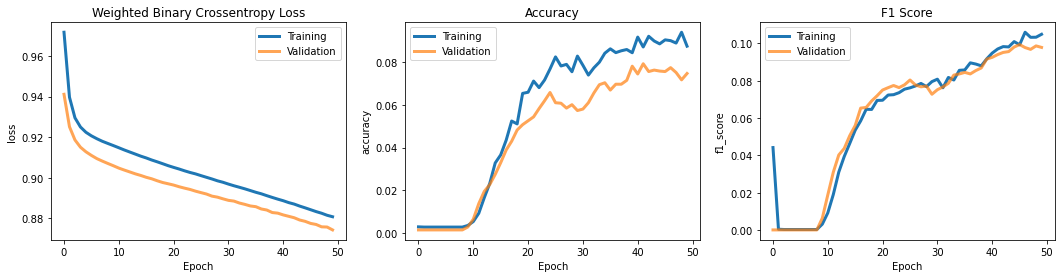

In [36]:
graph_history(history2)

This VGG-16 model has an interesting history over the epochs as both the training and validation losses went down steadily. Around the 10 epoch mark, both the accuracies and both the f1 scores increase substantially. This could be a result of using the SGD method that can take longer than Adam to optimize. From 10 epochs to the cap of 50, there was a steady increase in accuracy and f1 score, with some divergence in accuracy between the training and validation, perhaps signaling overfitting. However, the validation loss remained below the training loss which points to proper learning as opposed to overfitting. Notice also that the magnitude of the change in loss over 50 epochs is smaler (compared to other models), meaning we may not have been learning that quickly. While increasing the learning rate theoretically may have let us reach a better solution within 50 epochs, when tried, it performed significantly worse. Thus, the model was left with a learning rate of 1e-4.

## Model 3 - DenseNet121 Transfer Learning
<hr style="height:2pt">
<a class="anchor" id="14"></a>

Are third and final model aimed to improve the transfer learning approach by utilizing a differnt pre-built and pre-trained architecture. Specifically we used the 121 layer DenseNet-121 which is typically know for good for feature extraction and was the model of choice by some who have done similar Chest-Xray analysis before. DenseNet contains 120 convolutional layers and has connections from shallow layers to deeper ones allowing features extracted early on to be used deeper in the network. Furthermore, it has fewer parameters than the VGG-16 model, making it ideal for our time constraints. Like VGG-16, DenseNet has also been trained and has ImageNet (the weights from which we load), and used for classification, so for similar reasons to VGG16 it suits our task at hand.

We again add a global average pooling layer and then an ouput layer with 14 nodes and sigmoid activation. This time, we set all DenseNet layers to be untrainable and rather just trained the weights in layers we added. This was done to conserve training time as training all of DenseNet again could be very time-costly.

<span style=font-size:13pt;>Model Architecture</span>

In [37]:
K.clear_session()
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet121
def define_model_dn(in_shape=(240, 240, 3), out_shape=14):
    model3 = DenseNet121(include_top=False, input_shape=in_shape, weights='imagenet')
     # mark loaded layers as not trainable
    for layer in model3.layers:
        layer.trainable = False
        # add new classifier layers
    o=model3.output
    ga = GlobalAveragePooling2D()(o)
    output = Dense(out_shape, activation='sigmoid')(ga)
    # define new model
    model3 = tf.keras.Model(inputs=model3.inputs, outputs=output)
    # compile model
#     model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, amsgrad=False),
#                    loss=get_weighted_loss(pos_weights, neg_weights), metrics=['acc', f1_metric])
    return model3

model3 = define_model_dn()


The training for Model 3 was quite similar to that in Model 1, with a batch size of 32, the same Early Stopping callback, and the Adam optimizer with 1e-4 learning rate. We again used weighted loss and the same accuracy and F1 metrics. The only difference was due to previous runs where the model seemed to still be learning at 50 epochs, we increased the maximum to 100.

<span style=font-size:13pt;>Model Training</span>

In [38]:
# es = EarlyStopping(monitor='val_loss',patience=10, verbose=1, mode='min', restore_best_weights=True)
# history3 = model3.fit(dataset_train.batch(64).shuffle(buffer_size=64,seed=109,
#                                                     reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE), 
#                     validation_data=dataset_val.batch(64).shuffle(buffer_size=64,seed=109,
#                                                     reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE), epochs=100,
#                   callbacks=[es])

In [39]:
# model3.save_weights("DenseNet_trained_model_weights.h5")
model3.load_weights("DenseNet_trained_model_weights.h5")

In [40]:
# np.save('history3.npy',history3.history)
history3=np.load('history3.npy',allow_pickle='TRUE').item()

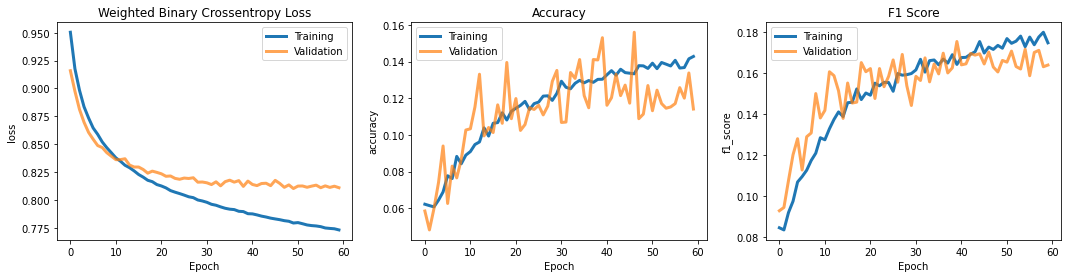

In [41]:
graph_history(history3)

These plots look relatively standard for fitting neural networks as our model initially improves quickly and then flattens off. Around Epoch 30, the preformance doesn't improve much and by epoch 60, the training stops due to early stopping. The validation accuracy is reasonably fluctuating and seems to diverge slightly by the end indicating overfitting (as does the loss). However, notice that the validation loss is th lowest and validation F1 Score is the highest in this model compared to the last two.

&nbsp;
&nbsp;
# PART 3: EVALUATION
<hr style="height:2pt">
<hr style="height:2pt">
<a class="anchor" id="15"></a>

*In this section, we evaluate the previous three models on a variety of metrics. We include F1 score, confusion matrices, and ROC/AUC metrics. We also exlore the focus of our convolutional networks by usinng saliency maps and GradCAM mappings.*

## Confusion Matrices
<hr style="height:2pt">
<a class="anchor" id="16"></a>

Because we have classification models with multiple classes, a good way to measure relative importance is to compare the confusion matrices of the different models. A confusion matrix showcases the number of true positives, true negatives, false positives, and false negatives that resulted from our models. We converted these values into rates where the true positive rate is the probability that an actual positive case will be classified as positive (calculated as TP/(TP+FN)), the true negative rate is the probability that an actual negative case will be classified as negative (calculated as TN/(TN+FP)), the false positive rate, the probability that a true negative case will be misclassified by the model (calculated as FP/(FP+TN)), and the false negative rate, the probability that a true positive case will be misclassified by the model (calculated as FN/(FN+TP)). This classification problem is about indicating whether or not a patient’s X-rays indicate that they have a thorax disease, so we want a model that maximizes the true positive rate, while minimizing the false negative rate. Still, it’s important to consider having high true negative rates and low false positive rates, as we don’t want to worry patients who truly do not have diseases nor do we want to overburden clinics with healthy patients. 

<span style=font-size:13pt;>Helpful Functions</span>

In [42]:
#Function to get metrics - true, predictions, f1 scores, multilabel confusion matrix
def get_metrics(dataset, model2):
    true1 = [y for x,y in dataset.batch(32)]
    preds1 = [model2.predict_on_batch(x) for x,y in dataset.batch(32)]

    true = [x for item in true1 for x in item]
    preds = [1*(x>0.5) for item in preds1 for x in item]
    p2 = [[x for x in item] for item in preds1]
    p2 = [x for item in p2 for x in item]
    
    f1 = f1_score(true,preds, average=None)
    ml = multilabel_confusion_matrix(true, preds) 

    return true, preds, p2, f1, ml

#Putting confusion matrices into a nicer format
def get_confusion_table(ml):
    tp, tn, fp, fn = {}, {}, {}, {}
    for matrix,classs in zip(ml,classes):
            scaled = pd.DataFrame(matrix/np.sum(matrix,axis=1).reshape(-1,1))
            tn[classs] = np.round(scaled[0][0],2)
            fn[classs] = np.round(scaled[0][1],2)
            fp[classs] = np.round(scaled[1][0],2)
            tp[classs] = np.round(scaled[1][1],2)
    return pd.DataFrame([tp,fn,fp,tn], index=['True Positive Rate', 'False Negative Rate', 'False Positive Rate', 'True Negative Rate'])


<span style=font-size:13pt;>Get Metrics and Matrices</span>

In [43]:
#Get metrics for each dataset
t1, p1, p21,f11, ml1 = get_metrics(dataset_test, model1)
t2, p2, p22,f12, ml2 = get_metrics(dataset_test, model2)
t3, p3, p23,f13, ml3 = get_metrics(dataset_test, model3)

#get confusion matrices
c1 = get_confusion_table(ml1)
c2 = get_confusion_table(ml2)
c3 = get_confusion_table(ml3)

In [44]:
print("Model1: ")
display(get_confusion_table(ml1))

Model1: 


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
True Positive Rate,0.67,0.63,0.74,0.68,0.78,0.64,0.73,0.53,0.57,0.66,0.63,0.79,0.67,0.70
False Negative Rate,0.33,0.37,0.26,0.32,0.22,0.36,0.27,0.47,0.43,0.34,0.37,0.21,0.33,0.30
False Positive Rate,0.38,0.33,0.34,0.22,0.36,0.38,0.48,0.32,0.36,0.45,0.48,0.49,0.44,0.41
True Negative Rate,0.62,0.67,0.66,0.78,0.64,0.62,0.52,0.68,0.64,0.55,0.52,0.51,0.56,0.59


Looking at the adapted confusion matrix for model 1, two main things appear to be true. First, the model does a pretty good job of having high true positive rates and low false negative rates for most disease classes. In particular, this model has higher true positive rates and lower false negative rates than the other two models for the following diseases: Atelectasis, Cardiomegaly, Consolidation, Effusion, Mass, Nodule, Pleural Thickening. However, the other thing that is true is that this model also has very high false positive rates and low true negative rates for most disease classes. This might reveal that this model is doing a good job of predicting positive cases because it’s overpredicting positive cases. This would be helpful for reducing the amount of patients that go undiagnosed, but can be a burden to the healthcare system. 

In [45]:
print("Model2: ")
display(get_confusion_table(ml2))

Model2: 


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
True Positive Rate,0.64,0.44,0.65,0.71,0.74,0.55,0.77,0.83,0.66,0.58,0.56,0.57,0.77,0.75
False Negative Rate,0.36,0.56,0.35,0.29,0.26,0.45,0.23,0.17,0.34,0.42,0.44,0.43,0.23,0.25
False Positive Rate,0.41,0.35,0.35,0.28,0.38,0.53,0.57,0.83,0.49,0.53,0.47,0.43,0.53,0.53
True Negative Rate,0.59,0.65,0.65,0.72,0.62,0.47,0.43,0.17,0.51,0.47,0.53,0.57,0.47,0.47


If we look at the adapted confusion matrix for model 2, it’s very clear that it performs similarly to model 1 in having high true positive rates and low false negative rates. In fact, it does this even better for Fibrosis, Hernia, Infiltration, Pneumonia, Pneumothorax. However, across the classes, it’s clear that the false positive rate is even higher than for model 1, meaning that the VGG model might actually be making the problem encountered with the baseline model even worse. 

In [46]:
print("Model3: ")
display(get_confusion_table(ml3))

Model3: 


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
True Positive Rate,0.66,0.46,0.70,0.74,0.77,0.65,0.45,0.67,0.59,0.57,0.59,0.52,0.44,0.73
False Negative Rate,0.34,0.54,0.30,0.26,0.23,0.35,0.55,0.33,0.41,0.43,0.41,0.48,0.56,0.27
False Positive Rate,0.34,0.25,0.29,0.24,0.31,0.26,0.16,0.17,0.37,0.36,0.45,0.22,0.25,0.30
True Negative Rate,0.66,0.75,0.71,0.76,0.69,0.74,0.84,0.83,0.63,0.64,0.55,0.78,0.75,0.70


Finally, taking a look at model 3, it’s clear that across the classes, the true positive rates and false negative rates are not as good as they are for model 1 or model 2. This model only has the highest true positive rates and lowest false negative rates for Edema and Emphysema. However,  for many of these diseases, the true positive rate and false negative rate were within a few percentage points of each other. Additionally, this model has across the board significantly higher true negative rates and lower false positive rates. Thus, the DN121 model might be slightly less accurate in predicting positive cases, but would decrease strain on healthy patients and the clinics treating these patients. 

<span style=font-size:13pt;>Get Weighted Average Across Classes</span>

In [47]:
#Display weighted average of each metric
mods = ["Baseline Model", "VGG Model", "DN121 Model"]
weights_pos = (freq_pos/sum(freq_pos))
weights_neg = (freq_neg/sum(freq_neg))

tp_w_avg = []
fn_w_avg = []
fp_w_avg = []
tn_w_avg = []



for item in [c1,c2,c3]:
    tp_w_avg.append(sum(item.iloc[0]*weights_pos))
    fn_w_avg.append(sum(item.iloc[1]*weights_pos))
    fp_w_avg.append(sum(item.iloc[2]*weights_neg))
    tn_w_avg.append(sum(item.iloc[3]*weights_neg))

avgs = pd.DataFrame([tp_w_avg, fn_w_avg, fp_w_avg,tn_w_avg], columns=mods,index=['True Positive Rate', 'False Negative Rate', 'False Positive Rate', 'True Negative Rate'])

# avgs.set_index(mods)
avgs

,Baseline Model,VGG Model,DN121 Model
True Positive Rate,0.669833,0.653154,0.638778
False Negative Rate,0.330167,0.346846,0.361222
False Positive Rate,0.388768,0.478807,0.281057
True Negative Rate,0.611232,0.521193,0.718943


On a whole, if we just want the “best” classification model as a whole for these 14 diseases, we can compare the average rates across disease classes for each model. Doing this, we see that as a whole, the model with the highest true positive rate and lowest false negative rate is the baseline model, but only marginally so, followed by the VGG model, and then the DN121 model. Considering the importance of having high true negative rates and low false positive rates,  the argument could be made that the DN121 model is actually the best model, because despite their true positive rate being slightly lower than the baseline model (0.64 vs 0.67) and their false negative rate being marginally higher (0.36 vs 0.33), it has significantly higher true negative rates (0.72 vs 0.61) and significantly lower false positive rates (0.28 vs 0.39). We will use additional metrics to compare the models, but the confusion matrices seem to show that the DN121 model is the best model.

## F1 Scores
<hr style="height:2pt">
<a class="anchor" id="17"></a>

F1 Scores are are helpful metric to evaluate the performance of models in classification problems, especially when the dataset being used is imbalanced. In our case, as shown in the EDA, some conditions are much more prevalent than others and thus the F1 Score is especially useful. The F1 score is defined as below:

$$precsion = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

$$F_1 = 2\cdot\frac{precision \cdot recall}{precision+recall} = \frac{TP}{TP+\frac{1}{2}(FP+FN)}$$

The precision gives us how "precise" our model is by seeing the fraction of the positive predictions are actually positive. Recall gives us the sensitivity of our model by determining the fraction of true positives that are actually predicted positive. Ideally, we'd optimize both metrics to be 1, meaning our model is both predicting the right ones to be positive and predicting all actual positives to be positive. In this ideal circumstance, we'd have an F1 score of 1, and thus the higher the F1 score the better. However this is difficult to do as there is generally a precision-recall tradeoff. In the case of imbalanced data, generally the recall may be high for common classes (we always predict 1 for common classes) while the precision may be lower. By contrast, in less common classes our precision may be high (we always predict no and thus have few false positives) but our recall may be low. The F1 score tries to evaluate both these metrics in one. We now investigate the F1 Scores of our model.

<span style=font-size:13pt;>Plot Results</span>

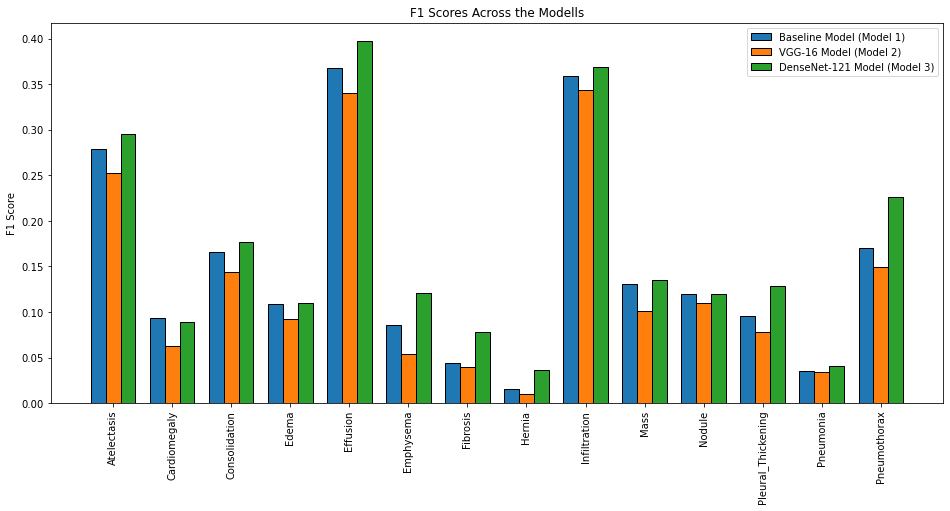

In [48]:
xv = np.arange(len(classes))
plt.figure(figsize=(16,7))
plt.bar(xv-0.25, f11, width=.25, edgecolor = 'black', label='Baseline Model (Model 1)')
plt.bar(xv, f12, width=.25, edgecolor = 'black', label='VGG-16 Model (Model 2)')
plt.bar(xv+0.25, f13, width=.25, edgecolor = 'black', label='DenseNet-121 Model (Model 3)')

plt.ylabel("F1 Score")
plt.title("F1 Scores Across the Modells")
  
plt.xticks(xv,classes, rotation=90)
plt.legend()
plt.show()

There are a few things to note in this graph. The first thing is that DenseNet-121 seems to be peforming best, followed by our Baseline Model, and finally the VGG-16 model. Across all but one disease, the F1 score of the DenseNet model is the highest (the exception is Cardiomegaly). The baseline model consistently has the second higheset score and VGG is the lowest. This is good evidence that our DenseNet model seem to be the best. The second notable thing is that the distribution of F1 scores across diseases closely parallels the distribution of disease in our dataset. This signals that even though we have tried to deal with class imbalance through our weighted loss function, by this metric the model seems better on more common diseases such as Infiltration and Effusion. Hernia, by contrast, has the lowest F1 score and the lowest prevalance in our dataset.

## ROC Curve / AUC Score
<hr style="height:2pt">
<a class="anchor" id="18"></a>

In [49]:
# https://stackoverflow.com/a/45335434

#Using code from class and stack overflow to get roc auc curves
def getroc_curve(true, preds, labels=classes, model = ""):
    aucroc=[]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(14):
        fpr[i], tpr[i], _ = roc_curve(np.array(true)[:,i], np.array(preds)[:, i])
        aucroc.append(roc_auc_score(np.array(true)[:,i], np.array(preds)[:,i]))

    for i in range(len(classes)):
        plt.figure(1, figsize=(10, 10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr[i], tpr[i],
                 label=classes[i] + " (" + str(round(aucroc[i],3)) + ")")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title(f'ROC curve for {model}')
        plt.legend(loc='best')
    plt.show()
    return aucroc

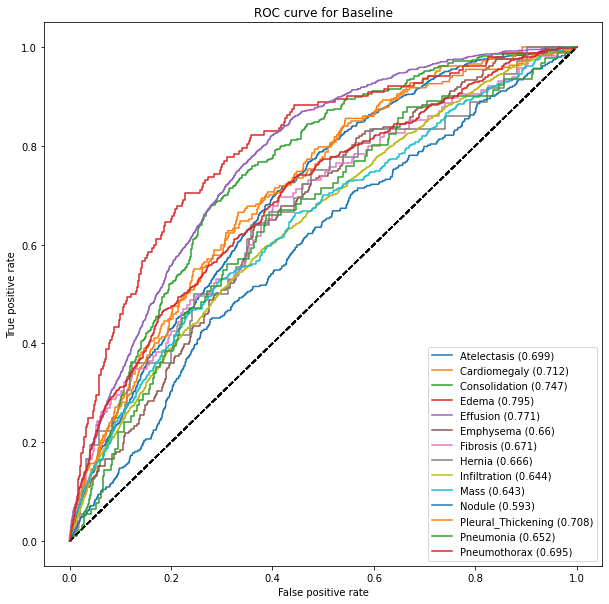

In [50]:
aucroc1 = getroc_curve(t1, p21, model="Baseline")

Above, we see the ROC curves and the associated AUCs for each of our labels for our baseline model. There are several important things to indentify: we can see that Edema has the best ROC curve, as it is closest to the top left, while Nodule has the worst ROC curve, as it is closest to the y = x line. That said, the two do not seem very far from one another, at least by the eye test, and many of the curves are overlapping in the middle. This is also supported by the AUC values: Edema has the highest at .795 while Nodule has the lowest at .593, showing that all values are within a relatively narrow range. We also see that all of the curves have similar shapes, as all are quite smooth and there are not many that are jagged.

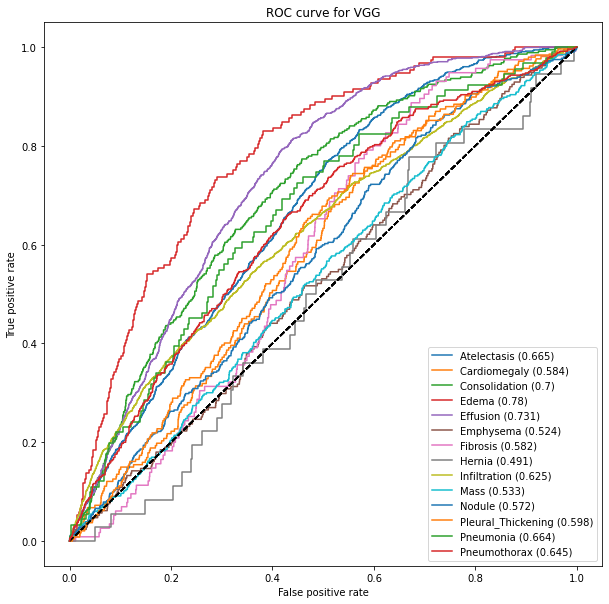

In [51]:
aucroc2 = getroc_curve(t2, p22, model="VGG")

Next, we can see the ROC curves and associated AUCs for our second model, the VGG transfer learning model, above. The first thing that jumps out is that the Hernia AUC is actually below .491, which means our model is actually doing worse than a coin flip. This is obviously concerning, but it is worth remembering that Hernia was our least common class, so perhaps it is not entirely surprising. On the upper end, our model once again performs best on Edema, as we can see from its curve being the closes to the top-left corner and its AUC at .78, slightly below what it was for our baseline model. There is also a bigger range of values, and while the curves in the middle remain close, they are not overlapping as much. Further, there are more that are much closer to the y = x line, indicating worse performance than above.

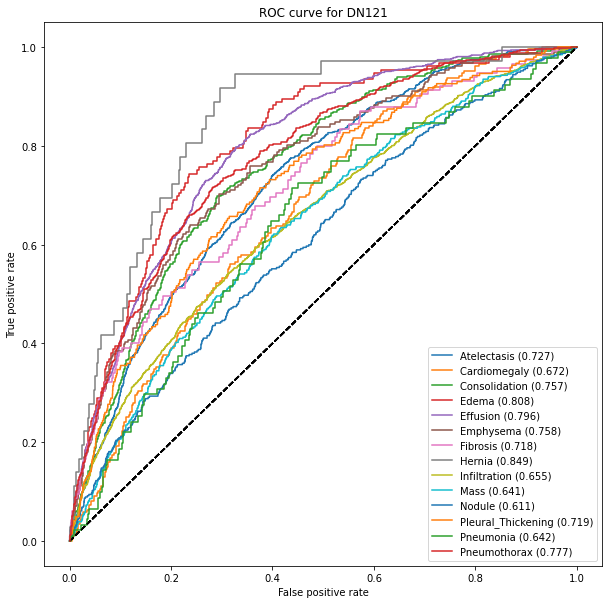

In [52]:
aucroc3 = getroc_curve(t3, p23, model="DN121")

Lastly, we observe above the ROC curves and AUC scores for the third model, the DN121 transfer learning model, above. Here, we have a new best class, and shockingly, it is Hernia, which now has an AUC of .849 after being below .5 in the last model. Edema remains strong, at .808, its highest value yet, and the second best class for this model. Performance on Nodule is once again the worst here, although it is slightly better than before, now with an AUC value  above .6 at .611. Overall, the range of values is still not incredibly wide, as we can see a lot of curves near each other and overlapping, although less than with our baseline model.

In [53]:
avgs = [sum(aucroc1 *weights_pos),sum(aucroc2 *weights_pos),sum(aucroc3 *weights_pos)]
aucrocdf = pd.DataFrame(dict(zip(mods,[aucroc1,aucroc2, aucroc3])), index=classes)
aucrocdf['Best Model'] = aucrocdf.idxmax(axis=1)
display(aucrocdf)
avdf = pd.DataFrame({"Weighted Average AUC":avgs}, index = mods)
display(avdf)

,Baseline Model,VGG Model,DN121 Model,Best Model
Atelectasis,0.699252,0.665228,0.726535,DN121 Model
Cardiomegaly,0.711924,0.583579,0.672119,Baseline Model
Consolidation,0.746598,0.700168,0.756632,DN121 Model
Edema,0.794553,0.780363,0.807750,DN121 Model
Effusion,0.771306,0.730945,0.795842,DN121 Model
Emphysema,0.659874,0.523871,0.757652,DN121 Model
Fibrosis,0.671489,0.582304,0.718297,DN121 Model
Hernia,0.665786,0.490920,0.849343,DN121 Model
Infiltration,0.644462,0.624709,0.655138,DN121 Model
Mass,0.643008,0.532537,0.641171,Baseline Model


,Weighted Average AUC
Baseline Model,0.689009
VGG Model,0.641122
DN121 Model,0.710400


Looking at all of our AUC values in the dataframe above, we can see that we do our best for most classes with the DN121 model, corroborating what we saw visually in the three plots above. We see that we perform best using the DN121 for 11 of the 14 classes, compared to 2 for the baseline (Cardiomegaly and Mass), and 1 for the VGG (Pneumonia). Furthermore, looking at the weighted average AUCs, we can see that this supports the same conclusion. It is highest for DN121 (roughly .71), followed by baseline (roughly .69) and then the VGG (.641). Thus, when we use ROC/AUC to evaluate our three models, it would seem to suggest that DN121 is the best, followed by the baseline, and VGG is the worst.

## GradCAM/Saliency Maps
<hr style="height:2pt">
<a class="anchor" id="19"></a>

In [54]:
def generate_viz(model, image, class1, num):
    #similar to hw4
    image = cv.imread(image)
    image = cv.resize(image,(240,240))    
    image = image.reshape(1,240,240,3) 
    image = image/255
    
    # grad-cam
    def model_modifier_function(cloned_model):
        cloned_model.layers[-1].activation = tf.keras.activations.linear 
        #https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html
    score = lambda x: x[:, num] #https://edstem.org/us/courses/17022/discussion/1293080

    gradcam = Gradcam(model,model_modifier=model_modifier_function,clone=True)
    cam = gradcam(score,image,penultimate_layer=-1)
    
    # saliency
    saliency = Saliency(model, model_modifier=model_modifier_function, clone=True)
    saliency_map = saliency(score,image,smooth_samples=20,smooth_noise=0.20)

    # plot 
    fig, axs = plt.subplots(1,3, figsize=(18,6))
    axs[0].imshow(image[0])
    axs[1].imshow(image[0])
    axs[1].imshow(saliency_map[0], alpha=.5, cmap='inferno')
    axs[2].imshow(image[0])
    axs[2].imshow(cam[0], alpha=.3, cmap='inferno')
    axs[0].set_title(f'Original X-ray, class = {class1}')
    axs[1].set_title(f'SmoothGrad saliency Map, class = {class1}')
    axs[2].set_title(f'Grad-CAM saliency heatmap, class = {class1}')
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

In [55]:
ex = x_test[x_test[classes[0]] == 1].sample(1, random_state=109)
test_row_1 = x_test[x_test[classes[12]] == 1].sample(1, random_state=111)
ex = pd.concat([ex, test_row_1])  

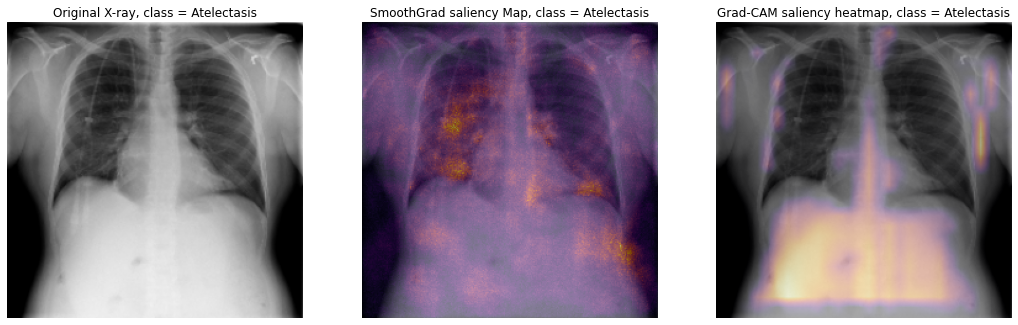

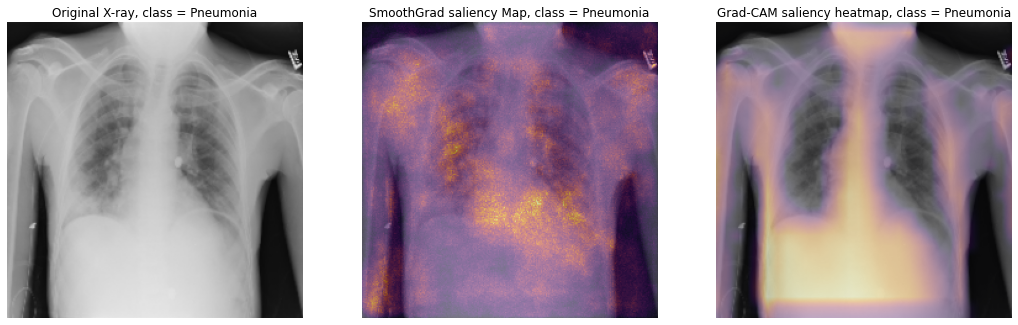

In [56]:
generate_viz(model1, ("resized_images/resized_images_new/" + ex.iloc[0]["Image Index"]), classes[0], 0)
generate_viz(model1, ("resized_images/resized_images_new/" + ex.iloc[1]["Image Index"]), classes[12], 12)

Above, we have some visualizations from the first model. We can see that based on the GradCAM saliency map, the model has trouble extracting features from within the chest/lung area. It seems to follow the chest's shape more than it needs to. However, we do have somewhat promising results on the SmoothGrad saliency map, as we can see that some of the 'heat zones' are where the lungs would be for both Atelactasis, a common class, and Pneumonia, a less common class. 

Overall, this baseline model does not perform exceptionally well in feature extraction, but we might expect to see better extraction with the other transfer learned models.

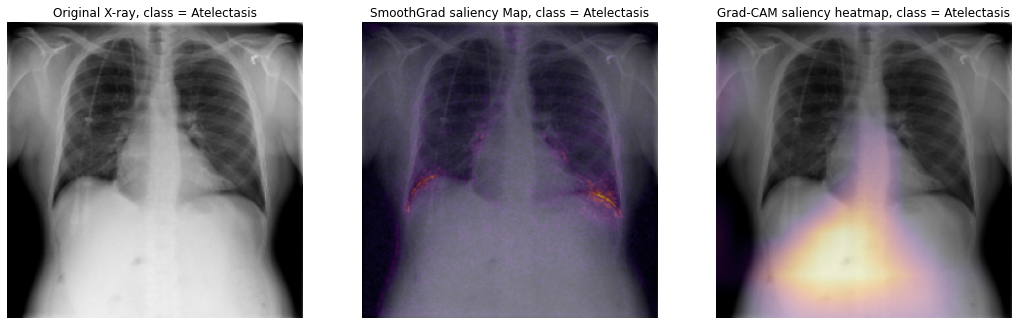

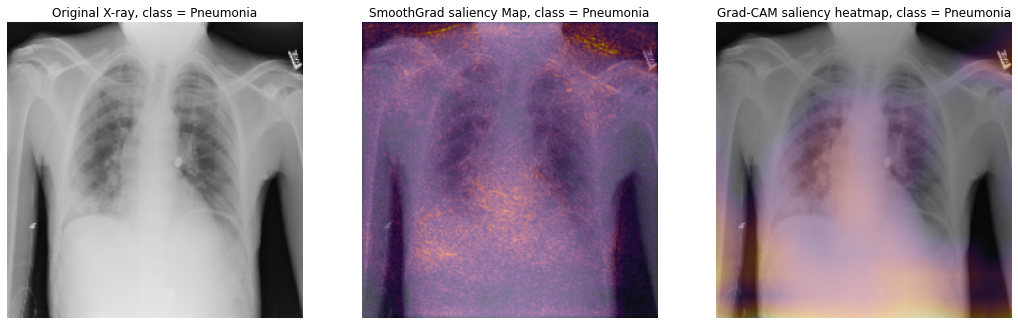

In [57]:
generate_viz(model2, ("resized_images/resized_images_new/" + ex.iloc[0]["Image Index"]), classes[0], 0)
generate_viz(model2, ("resized_images/resized_images_new/" + ex.iloc[1]["Image Index"]), classes[12], 12)

For the VGG model, we can see the same issues on the GradCAM saliency map, as the hot zones are more focused on the areas where the bones are, rather than the lung area where the disease would be. We do get slightly better results for the less common class of Pneumonia. For the more common Atelactasis, the model doesn't extract any good features.

Considering the SmoothGrad map, we can see that the model extracts very specific features in the lung area for Atelactasis, which seem to be most important for predicting the class, however is all over the place when the class is Pneumonia, which tells us that it might need a lot more time to train on the smaller classes, but can train on larger ones more easily.

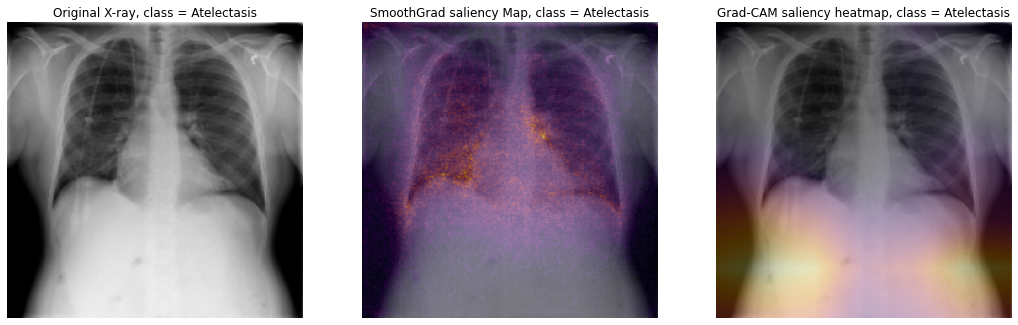

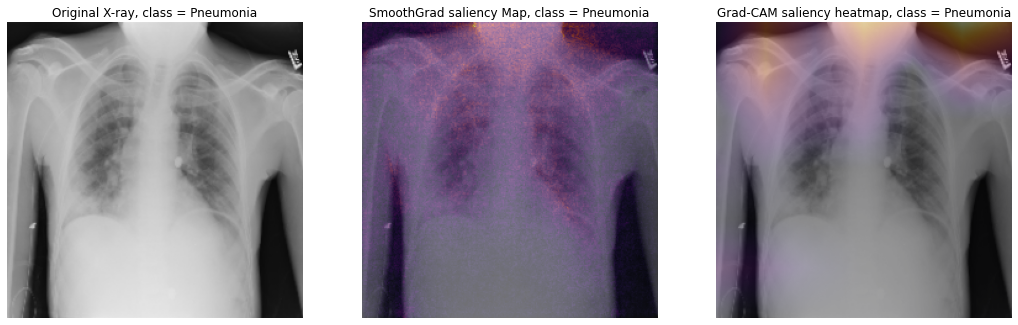

In [58]:
generate_viz(model3, ("resized_images/resized_images_new/" + ex.iloc[0]["Image Index"]), classes[0], 0)
generate_viz(model3, ("resized_images/resized_images_new/" + ex.iloc[1]["Image Index"]), classes[12], 12)

The DenseNet model was arguably our best one. It is very similar to the first two on the GradCAM maps, however seems to be slightly closer to extracting actual upper body and chest/throat features. Thus, Densenet seems to have learned slightly more. 

Furthermore, looking at the SmoothGrad maps, we have very promising results. For the larger class, Atelectasis, the model is heavily focused on the chest/lung area, where the disease mostly occurs, and has almost no weight elsewhere. Furthermore, for the less common class, Pneumonia, it has most of its concentration of heat near the upper chest and throat, again where that disease occurs. It does have some more spread in to the shoulder area, but still is better than the first two models.

Ultimately, while none of these plots are exactly perfect, they do show promising signs of our models being able to learn somewhat, especially via the SmoothGrad plots. The GradCAM plots, however, do not exacly line up with what we might expect a perfect model to do for feature extraction. Overall, however, we believe that these visualizations do indicate that the DenseNet model was able to learn the best, which is perhaps not suprising, given its prior use with similar problems. Furthermore, due to limited resources and computational power, it is reasonable to assume that DenseNet would be able to learn better with more training, given the results we have.

&nbsp;
&nbsp;
# Part 4: Discussion
<hr style="height:2pt">
<hr style="height:2pt">
<a class="anchor" id="20"></a>

*This section summarizes the performance of our models compared to each other and draws conclusions from our project. Additonally, we discuss the limitations of this project and future directions that could be explored.*

## Model Comparison
<hr style="height:2pt">
<a class="anchor" id="21"></a>

Based on the above metrics and visualizations, a clear trend stands out. We can see that more or less all four of the evaluations discussed above would point towards the DenseNet-121 model being the best, followed by the Baseline model, and then the VGG16 model.

There are a few possible explantions for such results. Since DenseNet121 is a deep CNN with the power to alleviate the vanishing gradient problem while also substantially reducing the number of parameters to help with computational cost, it may peform better especially with a relatively small training dataset.  DenseNet is also allows for better backpropogation of gradients through connected layers, perhaps making training earlier layers easier with small datasets by minimizing the vanishing gradient problem. VGG16, on the other hand, is substantially larger and more inefficient, making it less than ideal for the task at hand and more difficult to train. While both were trained on large sets of images (ImageNet) and can be used for feature extraction and classification, DenseNet121 is commonly used by other people whose research pertains to X-ray imaging (Chauhan et al.). Thus, we might expect DenseNet-121 to have a better performance on our images and classification, which indeed it does.

A surprising result was that VGG-16 not only performed worse than DenseNet-121, but also performed worse than our baseline custom model. Intuitively, we might expect a simple model like our baseline with few convolutional layers to not be as good as a complex VGG model trained on millions of images. However, the results were the opposite as VGG lagged behind in confusion matrix scores, f1 scores, and AUC as well as visual plots. This was surprising and may be due to the fact that our simple model could be trained relatively quickly and was trained specifically to the task at hand. While transfer learning may generally be a good idea, due to computational constraints, fully training a model like VGG on such a small dataset may not have been as effective as it is in theory.

Finally, looking at model performance as a whole, we see that there is significant room for improvement in predictions. Even our best model, the DenseNet-121, has per disease AUC scores signficantly lower than radiologists's performance and other models run on this topic (Rajpurkar et al.). Again, this could be due to the smaller dataset that we trained on and computational limitations limiting hyperparameter tuning on each model.

## Limitations
<hr style="height:2pt">
<a class="anchor" id="22"></a>

There are several limitations in this project that affect the way that some X-ray images are classified. First, the original dataset has some label noise. The labels are extracted from a corpus containing all of the images and their corresponding radiological report using Natural Language Processing (NLP) techniques. The researchers used the Natural Language Toolkit (NTLK) to split and tokenize the reports into sentences, and then parsed through these sentences using the BLLIP parser (Wang et al.). Overall, this method of label extraction proved to be >90% accurate, but because the dataset is made up of over 100,000 images and reports, many of the labels are erroneous. 

The second important limitation is the fact that our model uses imbalanced data. Over half of the dataset are images that result in “No Finding”, and many of the diseases (like Hernias) appear in very low frequencies. This can be a problem if our model is over-predicting “No Finding” for X-rays with some actual abnormalities. In the real world, high false negative rates pose a major problem for the patients, so trying to limit this issue of class imbalance as much as possible is important (Shultz et al.). Additionally, because of this class imbalance, different train and test splits can affect the accuracy of the model, making comparison a difficult task. 

Another limitation in our project is the fact that we were not able to use data augmentation techniques. We ended up using tensorflow datasets instead of tensorflow generators because of the significant reduction in time that it took for our models to fit using tensorflow datasets. The downside of this choice is the fact that we lose the ability to augment the data. 

Finally, using F1 scores as a measure of model comparison is useful, but the metric is not perfect. In particular, F1 scores give the same weights to the precision and recall of our model (Shmueli). The precision of the model is measured as true positives over actual results and the recall of the model is measured as the true positives over the predicted results. If, for example, 50,000 X-rays actually show some sort of disease, and our model predicts 100,000 images with diseases, then the recall of the model would be 100% but the precision would only be 50%. In reality, we probably care more about precision than recall, since we want to limit false positives. 


## Conclusion and Next Steps
<hr style="height:2pt">
<a class="anchor" id="23"></a>

Overall, we found the DenseNet121 transfer learned model to have the greatest predictive and learning power on the X-Ray dataset. We faced many challenges wrangling the data and developing our models, though after doing so we were able to split a large subset of the data into a training, validation, and test set, where we used the train and validation to classically create and train our models before evaluating on our test set. We saw that in all metrics (Confusion scores, F1 scores, AUC and ROC curve) and visualizations (Saliency Maps and GradCAM), the DenseNet model appeared to work best. 

Future work from here could involve fine-tuning the models, either by trying out different architectures or by using more data if not time constrained. As models of this nature have the potential to be incredibly impactful within the world of radiology, we would love to see them be able to diagnose diseases accurately and effectively, as this could have potentially life saving consequences. We could also see the model being more effective if it is also able to account for other information, including biographical data, medical history, and description of symptoms, for example, all of which would be relevant for a doctor in diagnosing patients and prescribing treatments.

&nbsp;
&nbsp;
# Works Cited
<hr style="height:2pt">
<hr style="height:2pt">
<a class="anchor" id="24"></a>

- Chauhan, Tavishee, et al. “Optimization and Fine-Tuning of DenseNet Model for Classification of COVID-19 Cases in Medical Imaging.” International Journal of Information Management Data Insights, vol. 1, no. 2, 2021, p. 100020., https://doi.org/10.1016/j.jjimei.2021.100020. 


- “Chest Pain.” Mayo Clinic, Mayo Foundation for Medical Education and Research, 20 Oct. 2021, https://www.mayoclinic.org/diseases-conditions/chest-pain/diagnosis-treatment/drc-20370842#:~:text=An%20X%2Dray%20of%20the,Computerized%20tomography%20(CT)%20scan.
 

 - Delrue, Louke, et al. “Difficulties in the Interpretation of Chest Radiography.” Medical Radiology, 2010, pp. 27–49., https://doi.org/10.1007/978-3-540-79942-9_2.
 

 - “Emphysema.” American Lung Association, https://www.lung.org/lung-health-diseases/lung-disease-lookup/emphysema#:~:text=Emphysema%20is%20one%20of%20the,alveoli%20(tiny%20air%20sacs).


 - HealthManagement.org. “Radiology Practice in the United States: Overview from the American College of Radiology.” HealthManagement, 3 May 2022, https://healthmanagement.org/c/imgfr/issuearticle/radiology-practice-in-the-united-states-overview-from-the-american-college-of-radiology#:~:text=The%20US%20has%20approximately%2030%2C000,radiologists%20are%20in%20academic%20practices.


- “Hiatal Hernia.” Mayo Clinic, Mayo Foundation for Medical Education and Research, 23 Feb. 2021, https://www.mayoclinic.org/diseases-conditions/hiatal-hernia/symptoms-causes/syc-20373379.


- Naveen, P, and B Diwan. “Pre-Trained VGG-16 with CNN Architecture to Classify X-Rays Images into Normal or Pneumonia.” 2021 International Conference on Emerging Smart Computing and Informatics (ESCI), 2021, https://doi.org/10.1109/esci50559.2021.9396997.


- Rajpurkar, Pranav, et al. “Deep Learning for Chest Radiograph Diagnosis: A Retrospective Comparison of the CheXNeXt Algorithm to Practicing Radiologists.” PLOS Medicine, vol. 15, no. 11, 2018, https://doi.org/10.1371/journal.pmed.1002686. 


- Redwankarimsony. “NIH Chest X-ray8 Classifier [CNN + Visualization].” Kaggle, Kaggle, 23 June 2020, https://www.kaggle.com/code/redwankarimsony/nih-chest-x-ray8-classifier-cnn-visualization/notebook. 


- Shmueli, Boaz. “Multi-Class Metrics Made Simple, Part II: The F1-Score.” Medium, Towards Data Science, 3 July 2020, https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1. 


- Shultz, Thomas R., et al. “Class Imbalance Problem.” Encyclopedia of Machine Learning, 2011, pp. 171–171., https://doi.org/10.1007/978-0-387-30164-8_110. 


- Yadav, Samir S., and Shivajirao M. Jadhav. “Deep Convolutional Neural Network Based Medical Image Classification for Disease Diagnosis.” Journal of Big Data, vol. 6, no. 1, 2019, https://doi.org/10.1186/s40537-019-0276-2.


- Young, Lorna. “Highlights from IMV 2019 X-Ray/Dr/CR Outlook Report.” IMV Medical Information Division, 20 May 2019, https://imvinfo.com/highlights-imv-2019-x-ray-dr-cr-outlook-report/#:~:text=IMV%20estimates%20that%20U.S.%20hospitals,procedures%20performed%20by%20U.S.%20hospitals%20(. 


- Xiaosong Wang, Yifan Peng, Le Lu, Zhiyong Lu, Mohammadhadi Bagheri, Ronald M. Summers. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly- Supervised Classification and Localization of Common Thorax Diseases, IEEE CVPR, pp. 3462-3471,2017
